In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import neural_tangents as nt
import flax.linen as nn
import sklearn.preprocessing

from neural_tangents import stax
from typing import Sequence
from jax import jit
from jax import random
import optax
import jax
import orbax
from flax.training import orbax_utils
import matplotlib.pyplot as plt

from src.kernels.reference_kernels import ARDKernel, NeuralNetworkGaussianProcessKernel
from src.kernels.approximate_kernels import StochasticVariationalGaussianProcessKernel
from src.mean_functions.classification_shared_mean_functions import NeuralNetworkSharedMeanFunction
from src.mean_functions.mean_functions import ConstantFunction, NeuralNetworkMeanFunction
from src.mean_functions.approximate_mean_functions import StochasticVariationalGaussianProcessMeanFunction
from src.gaussian_measures.reference_gaussian_measures import ReferenceGaussianMeasure
from src.gaussian_measures.approximate_gaussian_measures import (
    ApproximateGaussianMeasure,
)
from src.classification_models.distinct_means import ReferenceDistinctMeansClassificationModel as ReferenceClassificationModel
from src.classification_models.distinct_means import ApproximateDistinctMeansClassificationModel
from src.classification_models.shared_means import ApproximateSharedMeansClassificationModel 

from src.parameters.kernels.reference_kernels import NeuralNetworkGaussianProcessKernelParameters
from src.inducing_points_selection import ConditionalVarianceInducingPointsSelector
from src.utils.data import generate_batch

from jax.config import config

config.update("jax_enable_x64", True)
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

# Training Settings

In [2]:
log_likelihood_training = {
    "learning_rate": 1e-2,
    "number_of_epochs": 1000,
}
distinct_means_gwi={
    "learning_rate": 1e-7,
    "number_of_epochs": 10,
    "batch_size": 10,
    "el_matrix_diagonal_lower_bound": 1e-2
}
shared_means_gwi={
    "learning_rate": 1e-4,
    "number_of_epochs": 1000,
    "batch_size": 10,
    "el_matrix_diagonal_lower_bound": 1e-2
}
tempering={
    "learning_rate": 1e-5,
    "number_of_epochs": 10,
    "batch_size": 10,
}

subset_class_labels = [0, 1, 2]
number_of_training_points_per_label = 25
number_of_inducing_per_label = max(int(jnp.sqrt(number_of_training_points_per_label)), 2)
number_of_testing_points_per_label = 50
number_of_validation_points_per_label = 50

# Helper Functions

In [3]:
def one_hot_encode(y, labels):
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(labels)
    return label_binarizer.transform(y)


def plot_image_probabilities(y_probabilities, x, title, number_images_to_show=10):
    total_number_of_images = y_probabilities.shape[0]
    number_images_to_show = min(number_images_to_show, total_number_of_images)
    idx_images_to_show = list(
        range(total_number_of_images - number_images_to_show, total_number_of_images)
    )
    fig, ax = plt.subplots(
        number_of_classes,
        number_images_to_show,
        figsize=(
            (number_of_classes / 2) * number_images_to_show,
            (number_of_classes / 2) * number_of_classes + 1.5,
        ),
    )
    for i in range(number_of_classes):
        argsort_idx = jnp.argsort(y_probabilities[:, i])
        for j, idx in enumerate(idx_images_to_show):
            ax[i, j].imshow(x[argsort_idx[idx], :].reshape(28, 28))
            probabilities = [
                "{:0.2f}".format(x) for x in y_probabilities[argsort_idx[idx], :]
            ]
            probabilities = [
                x if k != i else "\mathbf{" + x + "}"
                for k, x in enumerate(probabilities)
            ]
            ax[i, j].set_title("$" + ", ".join(probabilities) + "$")
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
    plt.tight_layout()

# Data Preprocessing

In [4]:
from mnist import MNIST

mndata = MNIST("mnist_data")
mndata.gz = True
images, labels = mndata.load_training()
number_of_classes = len(subset_class_labels)

In [5]:
idx_labels_subset_class = [
    i for i in range(len(labels)) if labels[i] in subset_class_labels
]
subset_images = [images[idx] for idx in idx_labels_subset_class]
subset_labels = [labels[idx] for idx in idx_labels_subset_class]

In [6]:
label_dict = {}
for subset_class_label in subset_class_labels:
    label_dict[subset_class_label] = [
        idx
        for idx in range(len(subset_labels))
        if subset_labels[idx] == subset_class_label
    ]

In [7]:
SEED = 0
np.random.seed(SEED)
key = random.PRNGKey(SEED)
number_of_training_points = number_of_training_points_per_label * number_of_classes
number_of_inducing = number_of_inducing_per_label * number_of_classes
number_of_testing_points = number_of_testing_points_per_label * number_of_classes
number_of_validation_points = number_of_validation_points_per_label * number_of_classes

y = jnp.array(subset_labels).astype(int)
y = one_hot_encode(y=y, labels=subset_class_labels)

y_all = jnp.array(labels)
y_all = one_hot_encode(y=y_all, labels=list(range(10)))

x_train = jnp.concatenate(
    [
        jnp.array(
            [
                subset_images[idx]
                for idx in label_dict[subset_class_label][
                    :number_of_training_points_per_label
                ]
            ]
        )
        for subset_class_label in subset_class_labels
    ]
)
y_train = jnp.concatenate(
    [
        jnp.array(
            [
                y[idx]
                for idx in label_dict[subset_class_label][
                    :number_of_training_points_per_label
                ]
            ]
        )
        for subset_class_label in subset_class_labels
    ]
)


x_test = jnp.concatenate(
    [
        jnp.array(
            [
                subset_images[idx]
                for idx in label_dict[subset_class_label][
                    number_of_training_points_per_label : number_of_training_points_per_label
                    + number_of_testing_points_per_label
                ]
            ]
        )
        for subset_class_label in subset_class_labels
    ]
)
y_test = jnp.concatenate(
    [
        jnp.array(
            [
                y[idx]
                for idx in label_dict[subset_class_label][
                    number_of_training_points_per_label : number_of_training_points_per_label
                    + number_of_testing_points_per_label
                ]
            ]
        )
        for subset_class_label in subset_class_labels
    ]
)

x_validation = jnp.concatenate(
    [
        jnp.array(
            [
                subset_images[idx]
                for idx in label_dict[subset_class_label][
                    number_of_training_points_per_label + number_of_testing_points_per_label : number_of_training_points_per_label
                    + number_of_testing_points_per_label
                    + number_of_validation_points_per_label
                ]
            ]
        )
        for subset_class_label in subset_class_labels
    ]
)
y_validation = jnp.concatenate(
    [
        jnp.array(
            [
                y[idx]
                for idx in label_dict[subset_class_label][
                    number_of_training_points_per_label + number_of_testing_points_per_label : number_of_training_points_per_label
                    + number_of_testing_points_per_label
                    + number_of_validation_points_per_label
                ]
            ]
        )
        for subset_class_label in subset_class_labels
    ]
)

In [8]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_validation = x_validation.reshape(-1, 28, 28, 1)

## Inducing Points Selection

In [9]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Conv(32, (3, 3)),
    stax.Relu(),
    stax.AvgPool((2, 2), strides=(2, 2)),
    stax.Conv(64, (3, 3)),
    stax.Relu(),
    stax.AvgPool((2, 2), strides=(2, 2)),
    stax.Flatten(),
    stax.Dense(256),
    stax.Relu(),
    stax.Dense(1),
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames="get")

In [10]:
inducing_points_selector = ConditionalVarianceInducingPointsSelector()
key, subkey = random.split(key)
x_inducing = []
y_inducing = []
for label_idx in range(len(subset_class_labels)):
    label_idx = int(label_idx)
    x_train_label = x_train[
        label_idx*number_of_training_points_per_label:(label_idx+1)*number_of_training_points_per_label, :
    ]
    y_train_label = y_train[
        label_idx*number_of_training_points_per_label:(label_idx+1)*number_of_training_points_per_label
    ]
    x_inducing_label, idxs_inducing_label = inducing_points_selector.compute_inducing_points(
        key=subkey,
        training_inputs=x_train_label, 
        number_of_inducing_points=number_of_inducing_per_label, 
        kernel=NeuralNetworkGaussianProcessKernel(kernel_fn),
        kernel_parameters=NeuralNetworkGaussianProcessKernelParameters()
    )
    x_inducing.append(x_inducing_label)
    y_inducing.append(y_train_label[idxs_inducing_label])
x_inducing = jnp.concatenate((x_inducing))
y_inducing = jnp.concatenate((y_inducing))

# Reference Classification Model

In [11]:
class ConvNet(nn.Module):
    # https://flax.readthedocs.io/en/latest/getting_started.html
    number_of_outputs: int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.number_of_outputs)(x)
        return x.reshape(
            -1,
        )

In [12]:
reference_classification_model = ReferenceClassificationModel(
    x=x_inducing,
    y=y_inducing,
    gaussian_measures={
        str(label): ReferenceGaussianMeasure(
            x=x_inducing,
            y=y_inducing[:, i].reshape(-1),
            kernel=NeuralNetworkGaussianProcessKernel(kernel_fn),
            mean_function=ConstantFunction(),
        )
        for i, label in enumerate(subset_class_labels)
    },
)

In [13]:
reference_classification_model_parameters = (
    reference_classification_model.generate_parameters(
        {
            "gaussian_measures": {
                str(label): reference_classification_model.gaussian_measures[
                    str(label)
                ].generate_parameters(
                    {
                        "log_observation_noise": jnp.log(2.0),
                        "mean_function": {"constant": 0},
                        "kernel": {},
                    }
                )
                for label in subset_class_labels
            }
        }
    )
)

## Untrained Visualisations

### Inducing Set

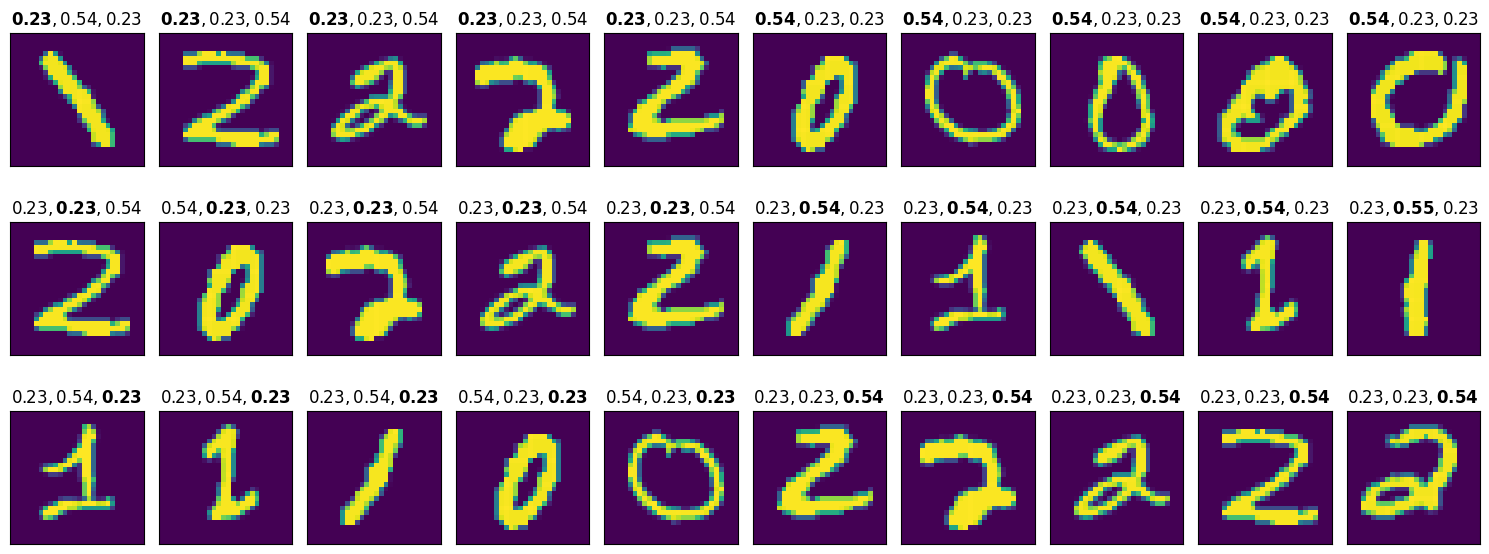

In [14]:
y_probabilities = reference_classification_model.predict_probability(
    parameters=reference_classification_model_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities,
    x=x_inducing,
    title="Reference GP (Untrained): Inducing Set Per Label",
)

### Test Set

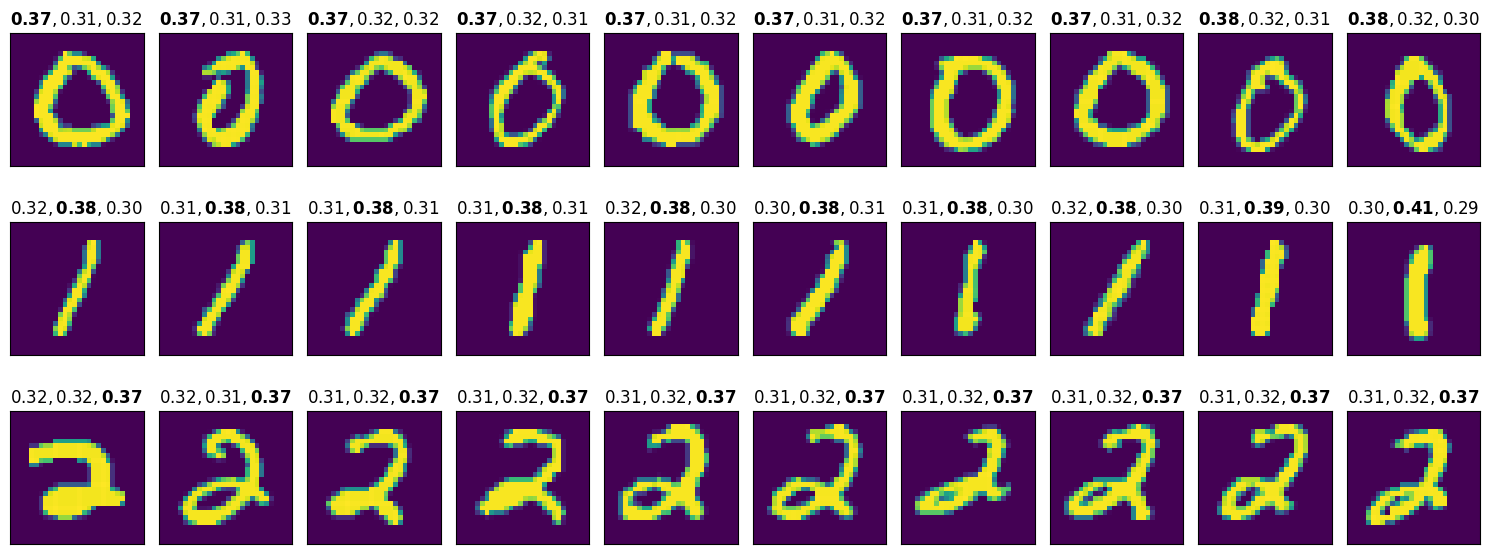

In [15]:
y_probabilities = reference_classification_model.predict_probability(
    parameters=reference_classification_model_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Reference GP (Untrained): Test Set Per Label"
)

## Log Likelihood Training

In [16]:
optimizer = optax.adam(log_likelihood_training["learning_rate"])
reference_classification_model_losses = []
opt_state = optimizer.init(reference_classification_model_parameters.dict())
reference_classification_model_losses.append(
    reference_classification_model.compute_negative_log_likelihood(
        parameters=reference_classification_model_parameters,
        x=x_inducing,
        y=y_inducing,
    )
)

In [17]:
for _ in tqdm(range(log_likelihood_training["number_of_epochs"])):
    gradients = jax.grad(
        lambda reference_classification_model_parameters_dict: reference_classification_model.compute_negative_log_likelihood(
            parameters=reference_classification_model_parameters_dict,
            x=x_inducing,
            y=y_inducing,
        )
    )(reference_classification_model_parameters.dict())
    updates, opt_state = optimizer.update(gradients, opt_state)
    reference_classification_model_parameters = (
        reference_classification_model.generate_parameters(
            optax.apply_updates(
                reference_classification_model_parameters.dict(), updates
            )
        )
    )
    reference_classification_model_losses.append(
        reference_classification_model.compute_negative_log_likelihood(
            parameters=reference_classification_model_parameters,
            x=x_inducing,
            y=y_inducing,
        )
    )

100%|██████████████████████████| 1000/1000 [1:13:22<00:00,  4.40s/it]


In [18]:
ckpt = reference_classification_model_parameters.dict()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('reference_classification_model.ckpt', ckpt, save_args=save_args, force=True)
reference_classification_model_parameters = reference_classification_model.generate_parameters(
    orbax_checkpointer.restore('reference_classification_model.ckpt')
)

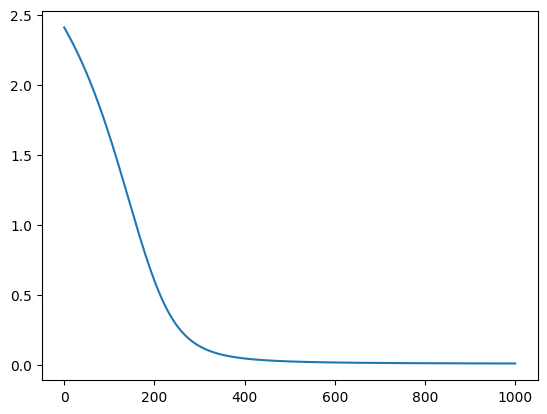

In [19]:
plt.plot(reference_classification_model_losses)

## Trained Visualisations

### Inducing Set

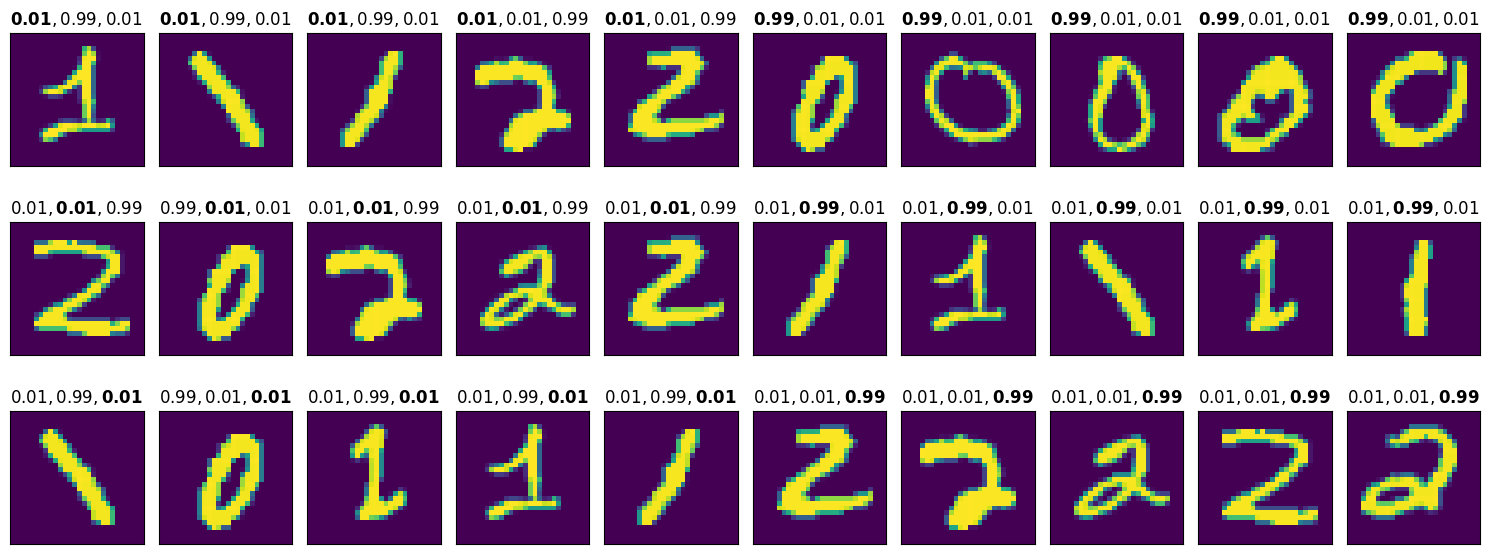

In [20]:
y_probabilities = reference_classification_model.predict_probability(
    parameters=reference_classification_model_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities,
    x=x_inducing,
    title="Reference GP (Trained): Inducing Set Per Label",
)

### Test Set

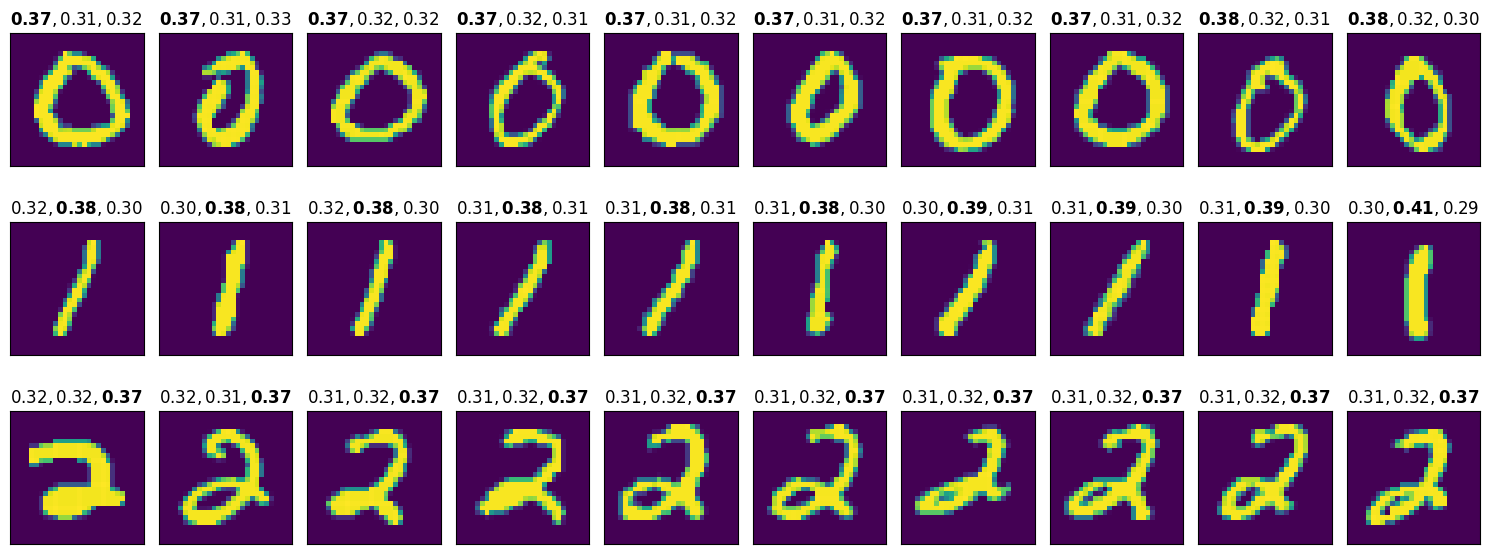

In [21]:
y_probabilities = reference_classification_model.predict_probability(
    parameters=reference_classification_model_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Reference GP (Trained): Test Set Per Label"
)

# Shared Mean Approximate Classification Model

In [22]:
shared_neural_network = ConvNet(len(subset_class_labels))

In [23]:
approximate_shared_means_classification_model = ApproximateSharedMeansClassificationModel(
    x=x_train,
    y=y_train,
    kernels={
        label: StochasticVariationalGaussianProcessKernel(
                reference_kernel_parameters=reference_classification_model_parameters.gaussian_measures[
                    label
                ].kernel,
                reference_kernel=reference_classification_model.gaussian_measures[
                    label
                ].kernel,
                log_observation_noise=reference_classification_model_parameters.gaussian_measures[
                    label
                ].log_observation_noise,
                inducing_points=reference_classification_model.gaussian_measures[
                    label
                ].x,
                training_points=x_train,
                el_matrix_diagonal_lower_bound=shared_means_gwi["el_matrix_diagonal_lower_bound"],
            )
        for label in reference_classification_model.labels
    },
    mean_function=NeuralNetworkSharedMeanFunction(
                neural_network=shared_neural_network,
            ),
    reference_classification_model=reference_classification_model,
    reference_classification_model_parameters=reference_classification_model_parameters,
)

In [24]:
approximate_classification_model_kernel_parameters = {}
for label in approximate_shared_means_classification_model.labels:
    key, subkey = random.split(key)
    approximate_classification_model_kernel_parameters[label] = (
        approximate_shared_means_classification_model.kernels[label].initialise_random_parameters(subkey)
    )
key, subkey = random.split(key)
approximate_shared_means_classification_model_parameters = approximate_shared_means_classification_model.generate_parameters(
    {
        "kernels": approximate_classification_model_kernel_parameters,
        "mean_function": {"neural_network": shared_neural_network.init(subkey, x_train)},
    }
)

## Untrained Visualisations

### Inducing Set

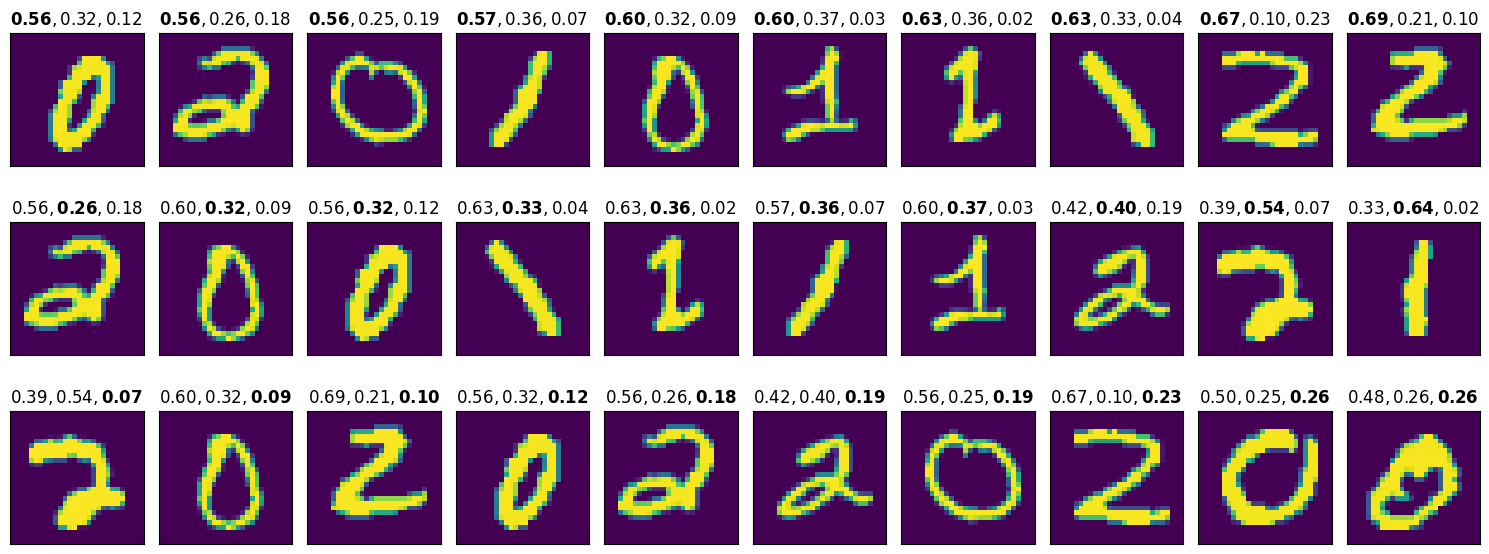

In [25]:
y_probabilities = approximate_shared_means_classification_model.predict_probability(
    parameters=approximate_shared_means_classification_model_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities,
    x=x_inducing,
    title="Approximate GP (Untrained): Inducing Set Per Label",
)

## GWI Training

In [26]:
optimizer = optax.adam(shared_means_gwi["learning_rate"])
opt_state = optimizer.init(approximate_shared_means_classification_model_parameters.dict())
approximate_shared_means_classification_model_losses = []

In [27]:
for _ in tqdm(range(shared_means_gwi["number_of_epochs"])):
    key, subkey = random.split(key)
    batch_generator = generate_batch(
        key=subkey,
        data=x_train,
        batch_size=shared_means_gwi["batch_size"],
    )
    while True:
        x_batch = next(batch_generator, None)
        if x_batch is None:
            break
        gradients = jax.grad(
            lambda approximate_shared_means_classification_model_dict: approximate_shared_means_classification_model.compute_gaussian_wasserstein_inference_loss(
                parameters=approximate_shared_means_classification_model_dict,
                x_batch=x_batch,
            )
        )(approximate_shared_means_classification_model_parameters.dict())
        updates, opt_state = optimizer.update(gradients, opt_state)
        approximate_shared_means_classification_model_parameters_new = (
            approximate_shared_means_classification_model.generate_parameters(
                optax.apply_updates(
                    approximate_shared_means_classification_model_parameters.dict(), updates
                )
            )
        )
        approximate_shared_means_classification_model_losses.append(
            approximate_shared_means_classification_model.compute_gaussian_wasserstein_inference_loss(
                parameters=approximate_shared_means_classification_model_parameters_new,
                x_batch=x_batch,
            )
        )
        if jnp.isnan(approximate_shared_means_classification_model_losses[-1]):
            break
        approximate_shared_means_classification_model_parameters = (
            approximate_shared_means_classification_model_parameters_new
        )

  7%|█▋                     | 71/1000 [7:44:46<101:21:23, 392.77s/it]


KeyboardInterrupt: 

In [28]:
ckpt = approximate_shared_means_classification_model_parameters.dict()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('approximate_shared_means_classification_model.ckpt', ckpt, save_args=save_args, force=True)
approximate_shared_means_classification_model_parameters = approximate_shared_means_classification_model.generate_parameters(
    orbax_checkpointer.restore('approximate_shared_means_classification_model.ckpt')
)

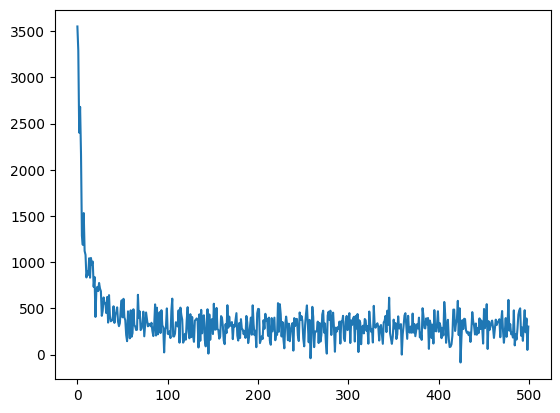

In [29]:
plt.plot(approximate_shared_means_classification_model_losses)

## Trained Visualisations

### Inducing Set

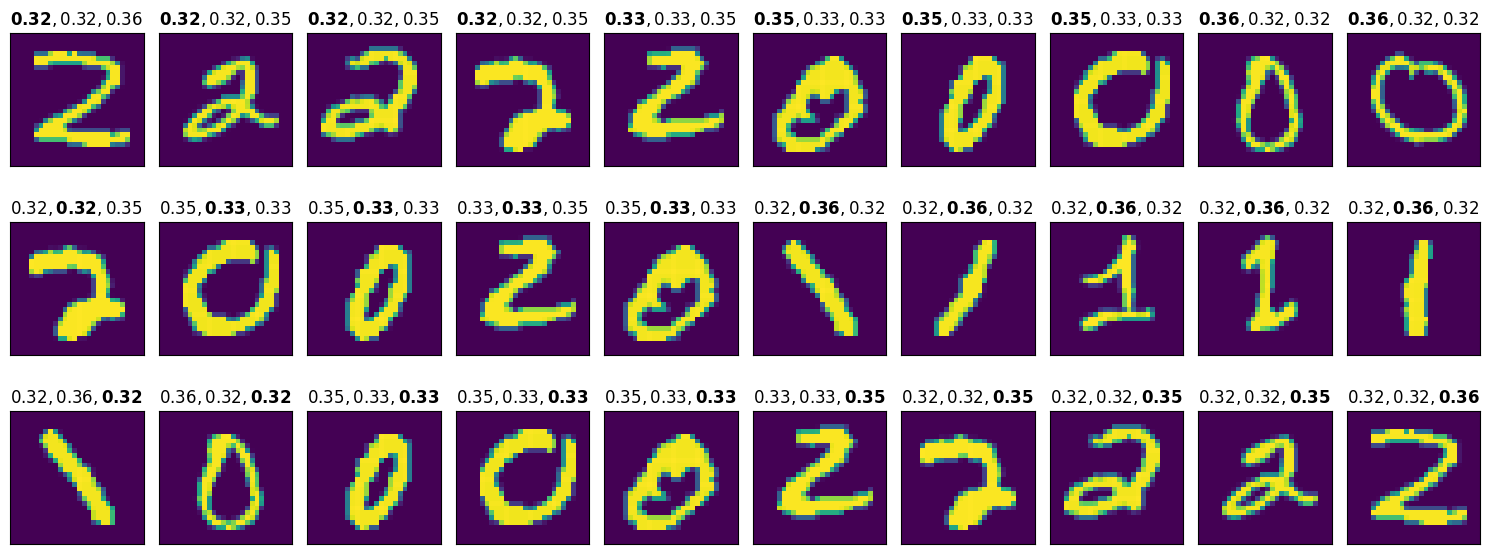

In [30]:
y_probabilities = approximate_shared_means_classification_model.predict_probability(
    parameters=approximate_shared_means_classification_model_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities,
    x=x_inducing,
    title="Approximate GP (Trained): Inducing Set Per Label",
)

### Train Set

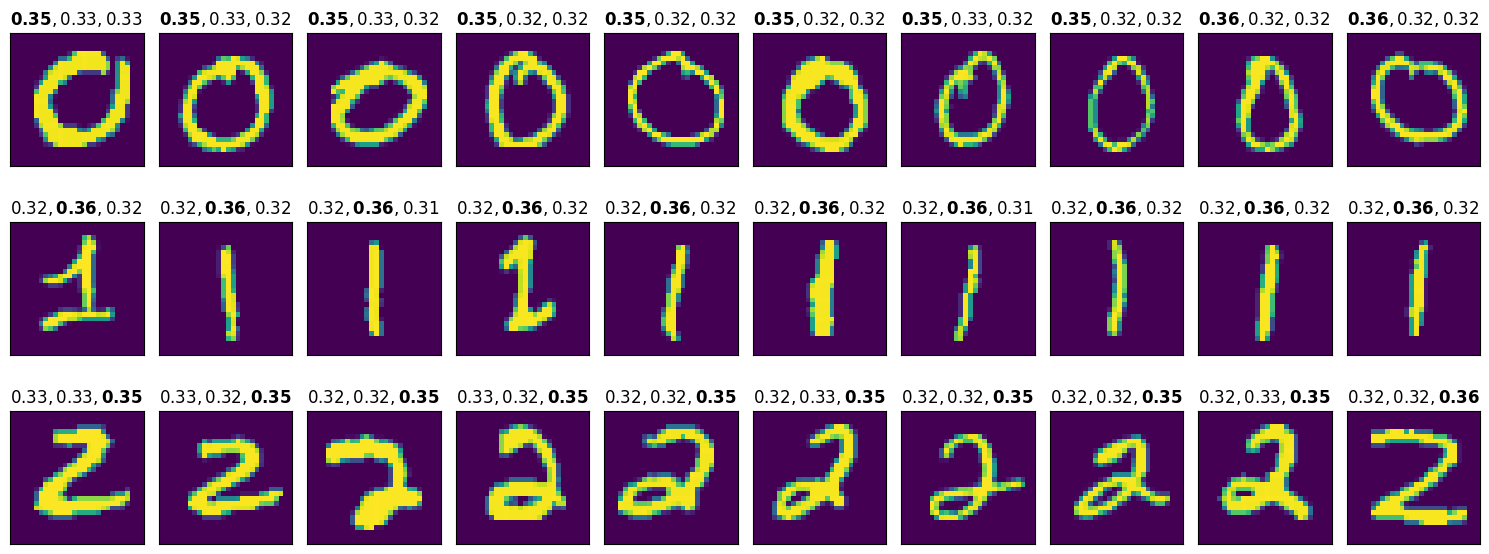

In [31]:
y_probabilities = approximate_shared_means_classification_model.predict_probability(
    parameters=approximate_shared_means_classification_model_parameters, x=x_train
)
plot_image_probabilities(
    y_probabilities, x=x_train, title="Approximate GP (Trained): Train Set Per Label"
)

### Test Set

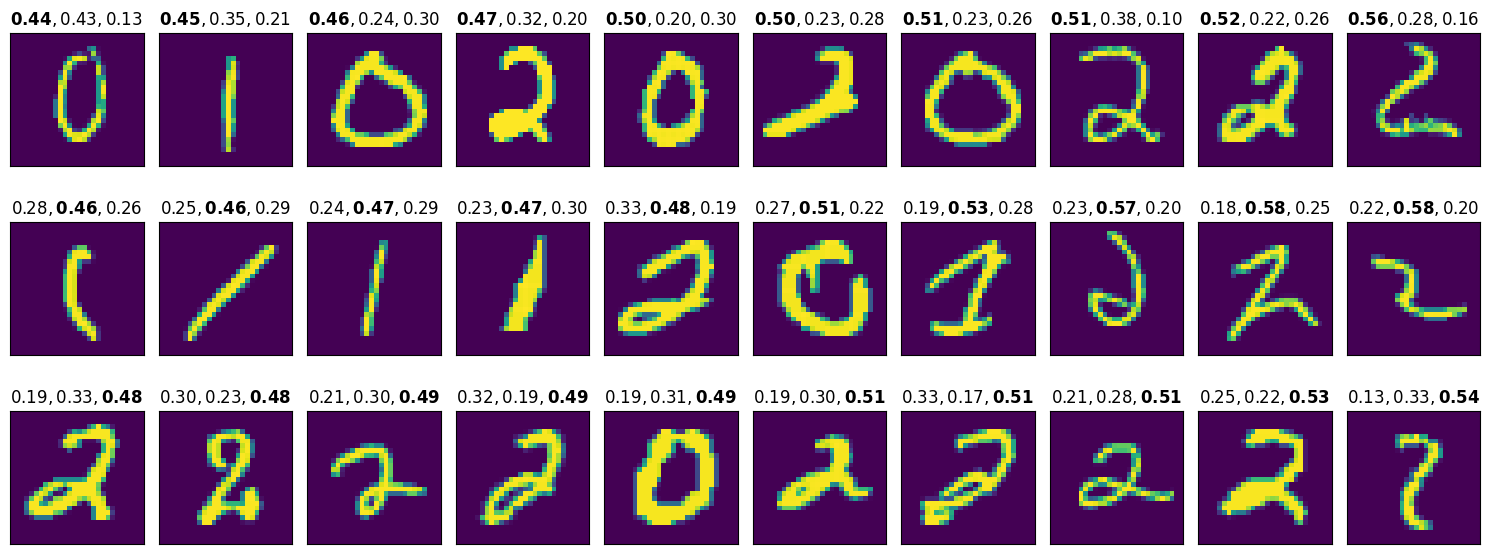

In [32]:
y_probabilities = approximate_shared_means_classification_model.predict_probability(
    parameters=approximate_shared_means_classification_model_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Approximate GP (Trained): Test Set Per Label"
)

# Tempering

In [33]:
from src.classification_models.classification_models import  TemperedClassificationModel

In [34]:
tempered_classification_model = TemperedClassificationModel(
    x=x_validation,
    y=y_validation,
    classification_model=approximate_shared_means_classification_model,
    classification_model_parameters=approximate_shared_means_classification_model_parameters,
)
tempered_classification_model_parameters = tempered_classification_model.generate_parameters(
    {"log_tempering_factors": jnp.exp(1.0)*jnp.ones(tempered_classification_model.number_of_labels)}
)

In [35]:
optimizer = optax.adam(tempering["learning_rate"])
tempered_losses = []
opt_state = optimizer.init(tempered_classification_model_parameters.dict())

In [36]:
for _ in tqdm(range(tempering["number_of_epochs"])):
    key, subkey = random.split(key)
    batch_generator = generate_batch(
        key=subkey,
        data=(x_validation, y_validation),
        batch_size=tempering["batch_size"],
    )
    while True:
        batch = next(batch_generator, None)
        if batch is None:
            break
        x_validation_batch, y_validation_batch = batch
        tempered_losses.append(
            tempered_classification_model.compute_negative_log_likelihood(
                parameters=tempered_classification_model_parameters,
                x=x_validation_batch,
                y=y_validation_batch,
            )
        )

        gradients = jax.grad(
            lambda tempered_classification_model_parameters_dict: tempered_classification_model.compute_negative_log_likelihood(
                parameters=tempered_classification_model_parameters_dict,
                x=x_validation_batch,
                y=y_validation_batch,
            )
        )(tempered_classification_model_parameters.dict())
        updates, opt_state = optimizer.update(gradients, opt_state)
        tempered_classification_model_parameters = (
            tempered_classification_model.generate_parameters(
                optax.apply_updates(tempered_classification_model_parameters.dict(), updates)
            )
        )

100%|████████████████████████████████| 10/10 [03:53<00:00, 23.38s/it]


In [37]:
ckpt = tempered_classification_model_parameters.dict()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('tempered_classification_model.ckpt', ckpt, save_args=save_args, force=True)
tempered_classification_model_parameters = tempered_classification_model.generate_parameters(
    orbax_checkpointer.restore('tempered_classification_model.ckpt')
)

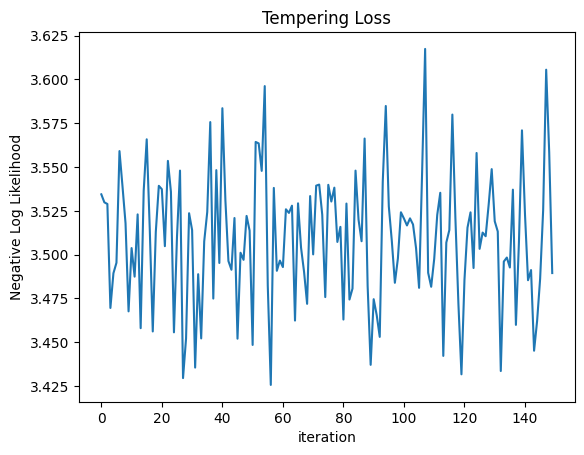

In [38]:
plt.plot(tempered_losses)
plt.title("Tempering Loss")
plt.xlabel("iteration")
plt.ylabel("Negative Log Likelihood")
plt.show()

### Inducing Set

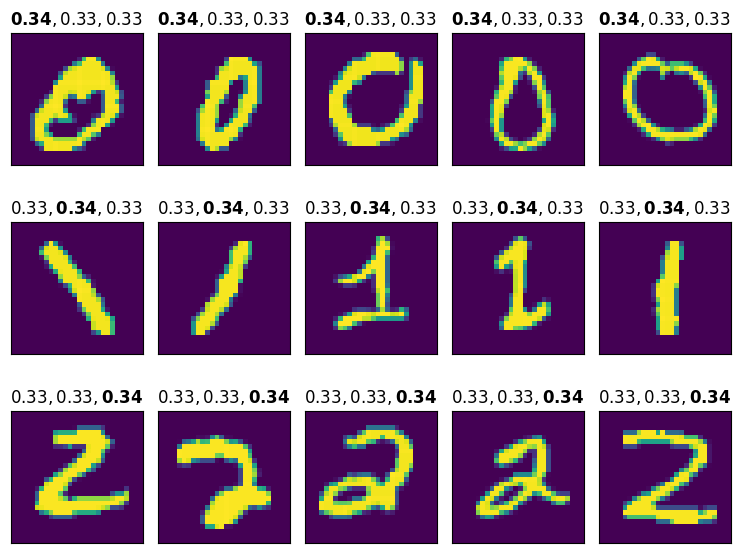

In [39]:
y_probabilities = tempered_classification_model.predict_probability(
    parameters=tempered_classification_model_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities,
    x=x_inducing,
    title="Approximate GP (Trained): Inducing Set Per Label",
    number_images_to_show=5,
)

### Train Set

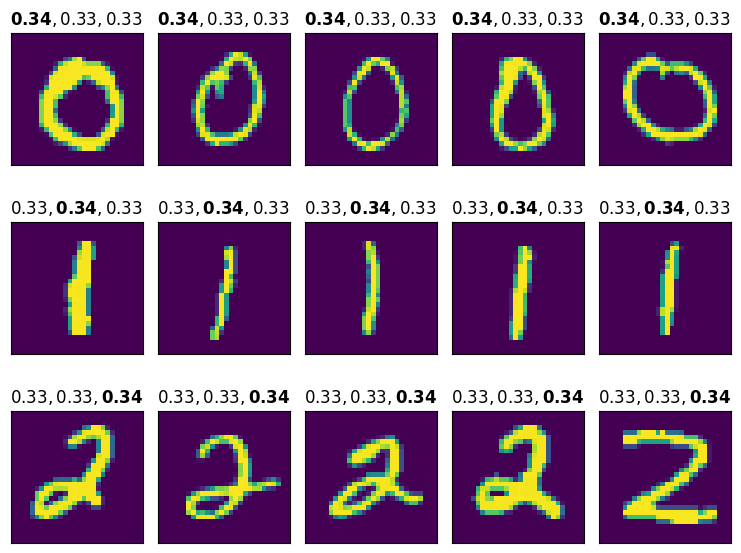

In [40]:
y_probabilities = tempered_classification_model.predict_probability(
    parameters=tempered_classification_model_parameters, x=x_train
)
plot_image_probabilities(
    y_probabilities, x=x_train, title="Approximate GP (Trained): Train Set Per Label", number_images_to_show=5,
)

### Test Set

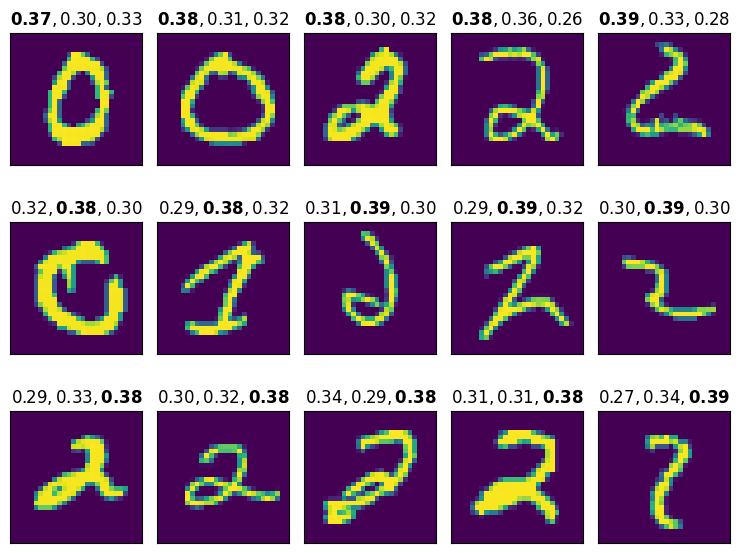

In [41]:
y_probabilities = tempered_classification_model.predict_probability(
    parameters=tempered_classification_model_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Approximate GP (Trained): Test Set Per Label", number_images_to_show=5,
)